In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\natha\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
# https://github.com/IHCA-Coding-to-Prevent-Coding/ML-SampleNeuralNet/blob/main/sampleneuralnet.py
# data from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [4]:
data = pd.read_csv('Tetuan City power consumption.csv')
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [32]:
#first week of data is training, second week is testing

splitPoint = 144*7

testing = data.iloc[:splitPoint, [6]]
training = data.iloc[splitPoint:2*splitPoint, [1, 2, 3, 4, 5]]

testing = torch.tensor(testing.values)
training = torch.tensor(training.values)

# does not kill error, probably bad for model
training = training.float()
testing = testing.float()

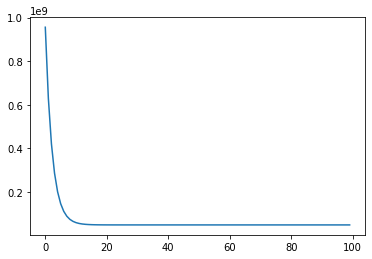

In [33]:
#testing = torch.randn(batchSize, seqLength, inputSize)

inputSize=5 # variables input
hiddenSize=1 # nodes of hidden layer
outSize=1 # power consumptoion in zone 1
batchSize= 144*7 # how many data points are in batch
lr = 0.1
seqLength=144 # num of time values per input
epochSize = 100

class extractTensor(nn.Module):
    def forward(self, x):
        tensor, hs = x
        return tensor.reshape(-1, hiddenSize) 

model = nn.Sequential(
    nn.LSTM(inputSize, hiddenSize),
    extractTensor(),
    nn.Linear(hiddenSize, outSize)
)

def lossFunc(data=training, comparison=testing, model=model):
    prediction = model(data)

    MSEloss = torch.nn.MSELoss()
    output = MSEloss(prediction, comparison)
    
    return output

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

lossList = []
for i in range(epochSize):
    loss = lossFunc()
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(lossList)